In [37]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import pymaster as nmt
from DES_analysis import *

Data import

In [38]:
hdufid = fits.open('data/sim_3x2_fiducial_nla.fits')
cls_fid = hdufid['galaxy_shear_cl'].data

hdudes = fits.open('data/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits')

data_source = hdudes['nz_source'].data[:-1]
data_lens = hdudes['nz_lens'].data[:-1]

header_source = hdudes['nz_source'].header
header_lens = hdudes['nz_lens'].header

Create dictionary for the lens and source data with the bin number as key value. For the redshift callibration, we also get the mean redshift per bin.

In [39]:
#redshift bins Redmagic
z_lims = np.array([0.15,0.35,0.5,0.65,0.8,0.9])

bin_number_source = 4
zs = np.array(data_source['Z_MID'])
zs_bins = []
zs_means = []
nz_source_dict = {}
ngal_source_dict = {}
sige_source_dict = {}
for i in range(bin_number_source):
    z = zs[(zs >= z_lims[i]) & (zs < z_lims[i+1])]
    zs_bins.append(np.array(z))
    zs_means.append(np.mean(z))
    nz_source_dict[i] = data_source['BIN' + str(i+1)]
    ngal_source_dict[i] = header_source['NGAL_' + str(i+1)] * (60 * 180 / np.pi)**2 # gal/arcmin^2  -> gal/str
    sige_source_dict[i] = header_source['SIG_E_' + str(i+1)]


bin_number_lens = 5
zl = np.array(data_lens['Z_MID'])
zl_bins = []
zl_means = []
nz_lens_dict = {}
ngal_lens_dict = {}
for i in range(bin_number_lens):
    z = zl[(zl >= z_lims[i]) & (zl < z_lims[i+1])]
    zl_bins.append(np.array(z))
    zl_means.append(np.mean(z))
    nz_lens_dict[i] = data_lens['BIN' + str(i+1)]
    ngal_lens_dict[i] = header_lens['NGAL_' + str(i+1)] * (60 * 180 / np.pi)**2 # gal/arcmin^2  -> gal/str

Define bias parameters

In [40]:
#Biases REDMAGIC
galaxy_bias = np.array([1.7, 1.7, 1.7, 2.0, 2.0])  # lens galaxy bias for each lens bin
magnification_bias = np.array([1.3134, -0.5179, 0.3372, 2.2515, 1.9667])  # magnification bias for each lens bin
shear_calibration_bias = np.array([-0.0063,-0.0198,-0.0241,-0.0369])  # shear calibration bias for each source bin

#redshift shift for lens galaxsssies REDMAGIC
shift_params = np.array([0.006,0.001,0.004,-0.002,-0.007])
stretch_params = np.array([1,1,1,1,1.23])

#Intrinsic Alignment (IA)
IA_params = np.array([0.7,-1.36,-1.7,-2.5,1.0,0.62]) #a1,a2,alf1,alfa2,bTA,z0
C1_mean=5e-14 # h^2 Msun^-1 Mpc^3

Initialization, zmin=0.01 to avoid division by 0

In [41]:
c = cosmology()
zmin = 0.1
zmax = max(zs.max(), zl.max(),)
ps = power_spectrum(zmin=zmin, zmax=zmax,kmax=10)

kmin = 1.000e-04, kmax = 1.000e+01, chimin = 4.341e+02, chimax = 8.420e+03, zmin = 0.100, zmax = 5.990


In [68]:
# l bins are integers but close to the 
lmin = 8
lmax = 2048
n_bins = 32
nside = 1024

# Generate sqrt-spaced edges
sqrt_edges = np.linspace(np.sqrt(lmin), np.sqrt(lmax), n_bins + 1)
edges = sqrt_edges**2
edges = np.round(edges).astype(int)
edges[-1] = lmax + 1

# Create NaMaster binning object
b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
ell_arr = b.get_effective_ells()

In [42]:
nside = 256
npix = hp.nside2npix(nside)
pixwin = hp.pixwin(nside)
lmax = 3*nside-1
b = nmt.NmtBin.from_lmax_linear(lmax, nlb=10)
ell_arr = b.get_effective_ells()

In [43]:
cls_ge = np.zeros((5,4,lmax+1))
cls_ia = np.zeros((5,4,lmax+1))
cls_ia_mag = np.zeros((5,4,lmax+1))
cls_mag = np.zeros((5,4,lmax+1))

ells = np.linspace(2,lmax,lmax + 1)

for i in range(5):
    for j in range(4):
            nz_source = nz_source_dict[j]
            nz_lens = nz_lens_dict[i]   
            zl_mean = zl_means[i]         

            shift_lens = shift_params[i] if shift_params is not None else 0
            stretch_lens = stretch_params[i] if stretch_params is not None else 1
            shear = shear_calibration_bias[j] if shear_calibration_bias is not None else 0
            gb = galaxy_bias[i]
            mb = magnification_bias[j]

            cls_ge[i,j,:] = ps.lensing_power(l_bins=ells, galaxy_bias=gb, zl=zl, zs=zs, nz_lens=nz_lens, nz_source=nz_source, zl_mean=zl_mean, nz_lens_stretch=stretch_lens, nz_lens_shift=shift_lens,shear=shear)
            cls_ia[i,j,:] = ps.ia_power(l_bins=ells,zl=zl, zs=zs, nz_lens=nz_lens, nz_source=nz_source, zl_mean=zl_mean, nz_lens_stretch = 1,  nz_lens_shift = 0,  galaxy_bias=gb)
            cls_ia_mag[i,j,:] = ps.ia_mag_power(l_bins=ells,zl=zl, zs=zs, nz_lens=nz_lens, nz_source=nz_source, zl_mean=zl_mean,magnification_bias=mb, nz_lens_stretch = 1,  nz_lens_shift = 0, shear=shear)
            cls_mag[i,j,:] = ps.mag_power(l_bins=ells,zl=zl, zs=zs, nz_lens=nz_lens, nz_source=nz_source, zl_mean=zl_mean,magnification_bias=mb,nz_lens_stretch = 1,  nz_lens_shift = 0, shear=shear)

            

Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on IA power
Note: redshifts have been re-sorted (earliest first)
Working on IAxmagnification power
Note: redshifts have been re-sorted (earliest first)
Working on magnificatino power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on IA power
Note: redshifts have been re-sorted (earliest first)
Working on IAxmagnification power
Note: redshifts have been re-sorted (earliest first)
Working on magnificatino power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on IA power
Note: redshifts have been re-sorted (earliest first)
Working on IAxmagnification power
Note: redshifts have been re-sorted (earliest first)
Working on magnificatino power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: red

In [44]:
cls_gg = np.zeros((5,4,lmax+1))

for i in range(5):
    for j in range(4):
            nz_source = nz_source_dict[j]
            nz_lens = nz_lens_dict[i]   
            zl_mean = zl_means[i]         
            shift_lens = shift_params[i] if shift_params is not None else 0
            stretch_lens = stretch_params[i] if stretch_params is not None else 1
            shear = shear_calibration_bias[j] if shear_calibration_bias is not None else 0
            gb = galaxy_bias[i]
            mb = magnification_bias[j]
            cls_gg[i,j,:] = ps.galaxy_auto_power(l_bins=np.linspace(2,lmax,lmax + 1), galaxy_bias=gb, zl=zl, nz_lens=nz_lens, zl_mean=zl_mean, nz_lens_stretch=stretch_lens, nz_lens_shift=shift_lens)

 

Working on galaxy-galaxy power
Note: redshifts have been re-sorted (earliest first)
Working on galaxy-galaxy power
Note: redshifts have been re-sorted (earliest first)
Working on galaxy-galaxy power
Note: redshifts have been re-sorted (earliest first)
Working on galaxy-galaxy power
Note: redshifts have been re-sorted (earliest first)
Working on galaxy-galaxy power
Note: redshifts have been re-sorted (earliest first)
Working on galaxy-galaxy power
Note: redshifts have been re-sorted (earliest first)
Working on galaxy-galaxy power
Note: redshifts have been re-sorted (earliest first)
Working on galaxy-galaxy power
Note: redshifts have been re-sorted (earliest first)
Working on galaxy-galaxy power
Note: redshifts have been re-sorted (earliest first)
Working on galaxy-galaxy power
Note: redshifts have been re-sorted (earliest first)
Working on galaxy-galaxy power
Note: redshifts have been re-sorted (earliest first)
Working on galaxy-galaxy power
Note: redshifts have been re-sorted (earliest

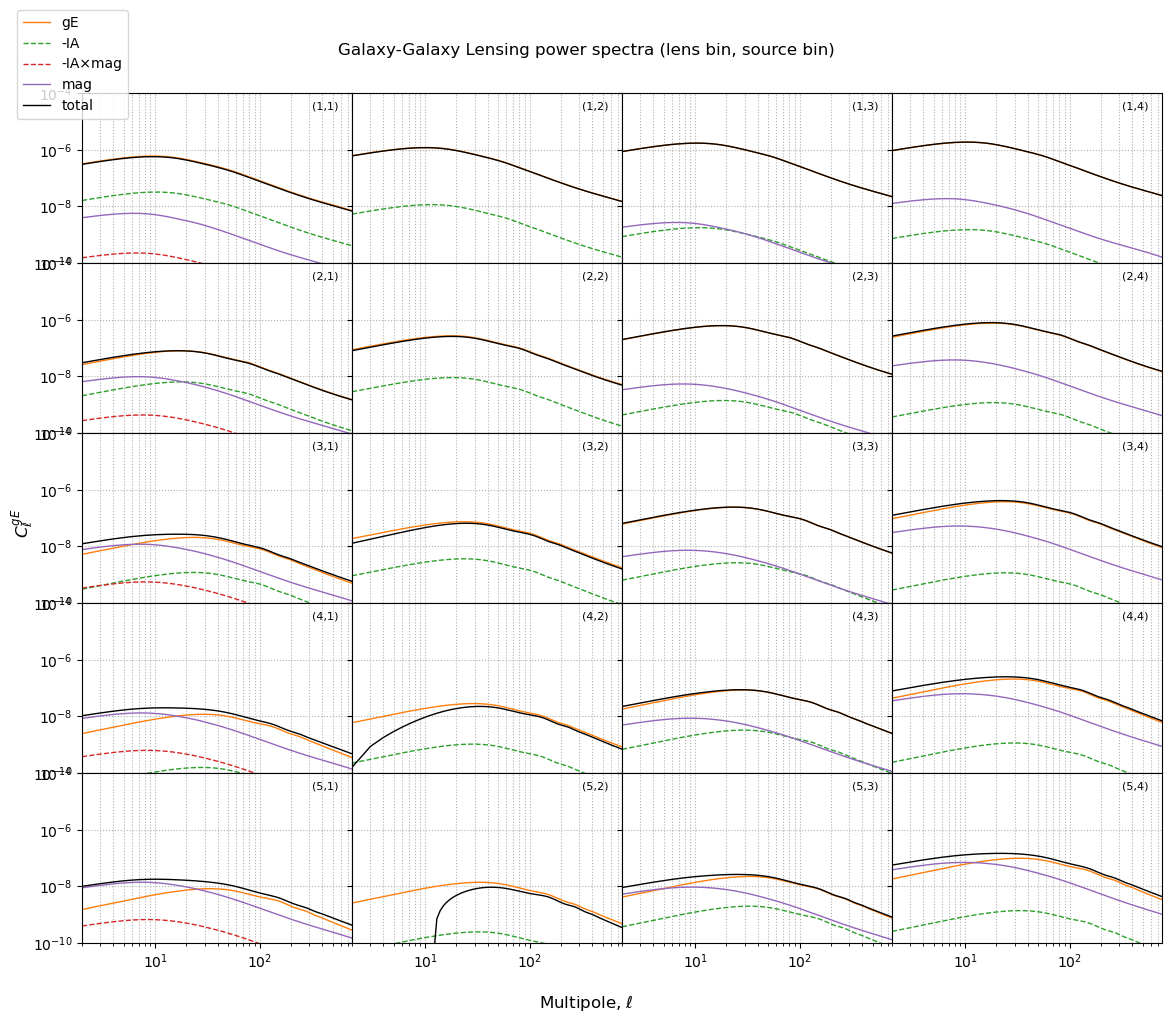

In [45]:
# Grid sizes
n_lens, n_source = 5, 4
fig = plt.figure(figsize=(12, 10))
fig.suptitle('Galaxy-Galaxy Lensing power spectra (lens bin, source bin)')

# Loop over bins
for i in range(n_lens):
    for j in range(n_source):
        
        # subplot index (1-based)
        idx = i * n_source + j + 1
        ax = fig.add_subplot(n_lens, n_source, idx)

        # Main spectra
        ax.plot(ells, cls_ge[i, j, :], color='C1', lw=1, label='gE')
        ax.plot(ells, -cls_ia[i, j, :], linestyle='--',color='C2', lw=1, label='-IA')
        ax.plot(ells, -cls_ia_mag[i, j, :],linestyle='--', color='C3', lw=1, label='-IA×mag')
        ax.plot(ells, cls_mag[i, j, :], color='C4', lw=1, label='mag')
        ax.plot(ells, cls_ge[i, j, :]+cls_ia[i, j, :]+cls_ia_mag[i, j, :]+cls_mag[i, j, :], color='black', lw=1, label='total')

        # bin label
        ax.text(0.95, 0.95, f"({i+1},{j+1})",
                transform=ax.transAxes, ha="right", va="top", fontsize=8)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.grid(True, which="both", ls=":")

        # Shared limits
        ax.set_xlim(2, lmax)
        ax.set_ylim(1e-10, 1e-4)

        # Clean labels inside the grid
        if j > 0:
            ax.set_yticklabels([])
        if i < n_lens - 1:
            ax.set_xticklabels([])

# Shared axis labels
fig.supxlabel(r"Multipole, $\ell$", fontsize=12)
fig.supylabel(r"$C_{\ell}^{gE}$", fontsize=12)

# Legend: take from the final ax
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left',
           bbox_to_anchor=(0.02, 1.02), ncol=1)

plt.subplots_adjust(wspace=0.0, hspace=0.0,
                    top=0.93, bottom=0.08, left=0.08, right=0.98)

plt.show()


kmin = 1.000e-04, kmax = 1.000e+03, chimin = 4.341e+02, chimax = 8.424e+03, zmin = 0.100, zmax = 6.000
Note: redshifts have been re-sorted (earliest first)


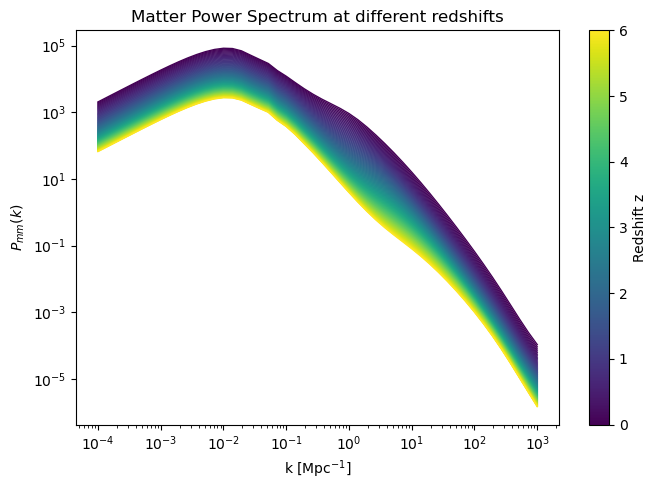

In [46]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis

ps = power_spectrum(zmin=0.1, zmax=6,kmax=1e3)

z_grid = np.linspace(0,6,100)
k_grid = np.logspace(-4,3,50)
Pmm_interp = ps.get_Pmm_interp()

fig, ax = plt.subplots(figsize=(7,5))
norm = Normalize(vmin=0, vmax=6)

for z in z_grid:
    Pmm = Pmm_interp(z, k_grid)
    ax.plot(k_grid, Pmm, color=viridis(norm(z)), lw=1)

# Colorbar
sm = ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Redshift z')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r'k [Mpc$^{-1}$]')
ax.set_ylabel(r'$P_{mm}(k)$')
ax.set_title('Matter Power Spectrum at different redshifts')

plt.tight_layout()
plt.show()


In [47]:
Pia_NLA = ps.get_Pia_interp(NLA=True)
Pia_TATT = ps.get_Pia_interp(NLA=False)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


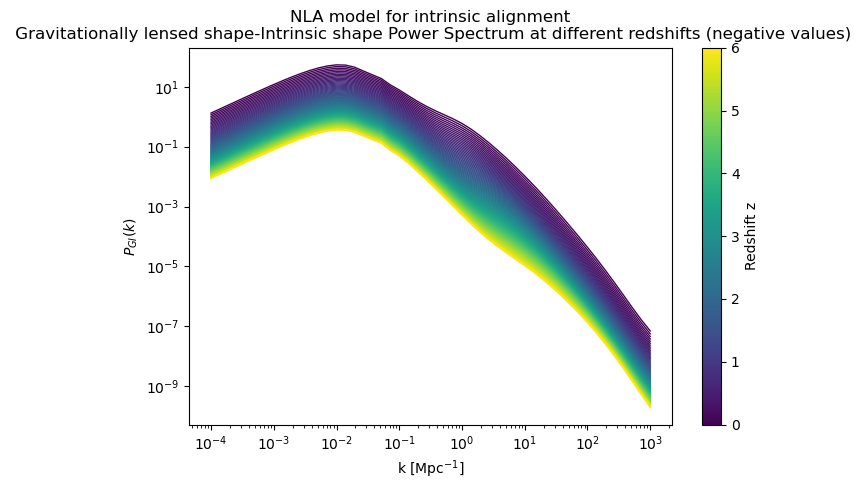

In [35]:
fig, ax = plt.subplots(figsize=(7,5))
norm = Normalize(vmin=0, vmax=6)

for z in z_grid:
    Pia = Pia_NLA((z, k_grid))
    ax.plot(k_grid, -Pia, color=viridis(norm(z)), lw=1)

# Colorbar
sm = ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Redshift z')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r'k [Mpc$^{-1}$]')
ax.set_ylabel(r'$P_{GI}(k)$')
ax.set_title('NLA model for intrinsic alignment\n Gravitationally lensed shape-Intrinsic shape Power Spectrum at different redshifts (negative values)')

plt.tight_layout()
plt.show()


In [48]:
cls_ee = np.zeros((5,4,lmax+1))

for i in range(5):
    for j in range(4):
            nz_source = nz_source_dict[j]
            nz_lens = nz_lens_dict[i]   
            zl_mean = zl_means[i]         
            shift_lens = shift_params[i] if shift_params is not None else 0
            stretch_lens = stretch_params[i] if stretch_params is not None else 1
            shear = shear_calibration_bias[j] if shear_calibration_bias is not None else 0
            gb = galaxy_bias[i]
            mb = magnification_bias[j]
            cls_ee[i,j,:] = ps.lensing_auto_power(l_bins=np.linspace(2,lmax,lmax + 1), zs=zs, nz_source=nz_source, shear=shear)


Working on lensing convergence auto power
Note: redshifts have been re-sorted (earliest first)
Working on lensing convergence auto power
Note: redshifts have been re-sorted (earliest first)
Working on lensing convergence auto power
Note: redshifts have been re-sorted (earliest first)
Working on lensing convergence auto power
Note: redshifts have been re-sorted (earliest first)
Working on lensing convergence auto power
Note: redshifts have been re-sorted (earliest first)
Working on lensing convergence auto power
Note: redshifts have been re-sorted (earliest first)
Working on lensing convergence auto power
Note: redshifts have been re-sorted (earliest first)
Working on lensing convergence auto power
Note: redshifts have been re-sorted (earliest first)
Working on lensing convergence auto power
Note: redshifts have been re-sorted (earliest first)
Working on lensing convergence auto power
Note: redshifts have been re-sorted (earliest first)
Working on lensing convergence auto power
Note: re

In [49]:
rows_array = np.loadtxt("pcls_ge_nside256.csv", delimiter=",")
pcls = np.zeros((5, 4, 2, len(ell_arr)))
for row in rows_array:
    i, j, s = row[:3].astype(int)
    pcls[i, j, s, :] = row[3:]

print(np.shape(pcls))

(5, 4, 2, 76)


In [50]:
cls_total_binned = np.zeros((5, 4, len(ell_arr)))
cls_total = cls_ge+cls_ia_mag+cls_ia+cls_mag

for i in range(5):
    for j in range(4):
        cls_total_binned[i, j, :] = b.bin_cell(cls_total[i, j, :] )

$$(\mathrm{SNR}_{ij})^2 = \sum_{\ell, \ell'} C_{\ell}^{\mathrm{th}}(i,j)\,[\mathrm{Cov}^{-1}]_{\ell,\ell'}^{(ij,ij)}\,C_{\ell'}^{\mathrm{th}}(i,j)$$

### Matched Filtering

We assume a data model

$$
y = A\,m + n, \qquad n \sim \mathcal{N}(0,\,C)
$$

where  
- $y$ is the data vector  
- $m$ is the known template (shape)  
- $A$ is an unknown amplitude  
- $C$ is the noise covariance  

---

### Matched-filter estimator for $A$

$$
\hat{A} = \frac{(C^{-1} m)\cdot y}{(C^{-1} m)\cdot m}
$$

---

### Variance of the estimator

$$
\sigma_A^2 = \frac{1}{(C^{-1} m)\cdot m}
$$

---

### Signal-to-noise ratio (SNR)

$$
\mathrm{SNR} = \frac{\hat{A}}{\sigma_A}
$$

If the model is correct ($y = A m$), then

$$
\mathrm{SNR} = A\, (C^{-1} m)\cdot m
$$

---

### Practical SNR from data

$$
\mathrm{SNR} = \frac{(C^{-1} m)\cdot y}{\sqrt{(C^{-1} m)\cdot m}}
$$


In [51]:
import os
outdir="cov_workspaces_nside256"

snr_dict = {}

for i in range(1, 6):        # density bins
    for j in range(1, 5): # shear bins
        # Load workspaces
        cw = nmt.NmtCovarianceWorkspace(fname=os.path.join(outdir, f"cw{i}{j}.fits"))
        wa = nmt.NmtWorkspace(fname=os.path.join(outdir, f"w{i}{j}.fits"))
        wb = nmt.NmtWorkspace(fname=os.path.join(outdir, f"w{i}{j}.fits"))

        # For Gaussian covariance, you need 4 Cl combinations:
        cl_tt = cls_gg[i-1,j-1,:] + 1.0 / ngal_lens_dict[i-1]
        cl_te = cls_total[i-1,j-1,:]
        cl_tb = np.zeros(lmax+1)
        cl_ee = cls_ee[i-1,j-1,:]
        cl_eb = np.zeros(lmax+1)
        cl_eb = np.zeros(lmax+1)
        cl_bb = np.zeros(lmax+1)

        if i == j:
            cl_ee += sige_source_dict[j-1]**2 / ngal_source_dict[j-1]
            cl_bb += sige_source_dict[j-1]**2 / ngal_source_dict[j-1]

        # Compute Gaussian covariance (bandpowers, not pseudo)
        cov = nmt.gaussian_covariance(
            cw, 0, 2, 0, 2,
            [cl_tt],                  
            [cl_te, cl_tb],          
            [cl_te, cl_tb],        
            [cl_ee, cl_eb, cl_eb, cl_bb], 
            wa, wb
        ).reshape([len(ell_arr), 2, len(ell_arr), 2])

        cov_EE = cov[:, 0, :, 0] 

        # Invert covariance safely
        cov_inv = np.linalg.pinv(cov_EE)

        # Define data and template
        y = pcls[i-1, j-1, 0, :]
        m = cls_total_binned[i-1, j-1, :]

        # Compute C^{-1} m
        Cm = cov_inv @ m

        # Compute matched-filter amplitude estimator A_hat
        A_hat = (Cm @ y) / (Cm @ m)

        # Variance of A_hat
        sigmaA2 = 1.0 / (Cm @ m)

        # Matched-filter SNR
        snr = A_hat / np.sqrt(sigmaA2)

        snr_dict[(i, j)] = snr


In [ ]:
%pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 462.3 kB/s  0:00:24m0:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [56]:
import pandas as pd

# Assuming snr_dict[(a1,a2,b1,b2)] is filled
rows = []
for (i,j), snr in snr_dict.items():
    rows.append({
        "Lens bin": i,
        "Source bin": j,
        "SNR": snr
    })

# Create DataFrame
snr_table = pd.DataFrame(rows)

# Sort nicely by bins
snr_table = snr_table.sort_values(["Lens bin", "Source bin"])

# Display nicely
print(snr_table.to_string(index=False))

# Save to CSV
snr_table.to_csv(f"snr_table_nside{nside}.csv", index=False)

 Lens bin  Source bin       SNR
        1           1 13.955422
        1           2 61.212528
        1           3 75.901456
        1           4 66.128762
        2           1 17.429138
        2           2  8.223255
        2           3 49.620961
        2           4 56.123856
        3           1  3.064081
        3           2  9.748347
        3           3 13.232780
        3           4 49.795652
        4           1 11.503754
        4           2  7.429560
        4           3  6.133938
        4           4 13.127125
        5           1 -0.691415
        5           2 -2.697906
        5           3 -2.603891
        5           4 13.763449


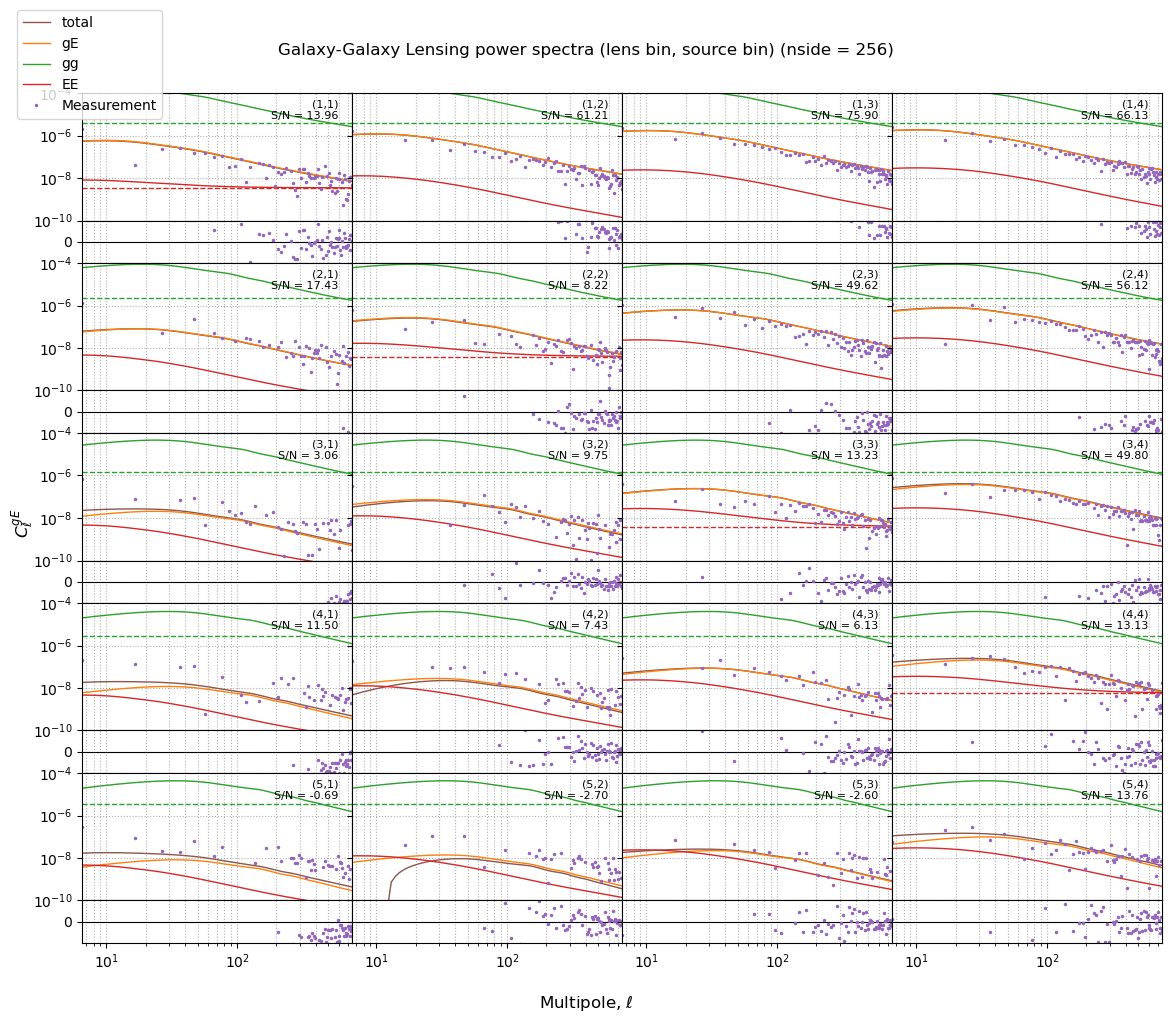

In [57]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, FixedFormatter

# Grid sizes
n_lens, n_source = 5, 4

ells = np.linspace(2,lmax,lmax+1)

# --- Create figure and GridSpec with smaller height ratio for residuals ---
fig = plt.figure(figsize=(12, 10))
fig.suptitle(f'Galaxy-Galaxy Lensing power spectra (lens bin, source bin) (nside = {nside})')

gs = GridSpec(n_lens * 2, n_source, figure=fig, 
              height_ratios=[3, 1]*n_lens,  # main:residual ratio 3:1
              hspace=0.0, wspace=0.0)       # no gaps

# --- Loop over bins ---
for i in range(n_lens):
    for j in range(n_source):
        # Main and residual axes stacked vertically, touching
        ax_main = fig.add_subplot(gs[2*i, j])
        ax_resid = fig.add_subplot(gs[2*i + 1, j], sharex=ax_main)

        # --- Main spectra ---
        ax_main.plot(ells, cls_total[i, j, :], color='C5', lw=1, label='total')
        ax_main.plot(ells, cls_ge[i, j, :], color='C1', lw=1, label='gE')
        ax_main.plot(ells, cls_gg[i, j, :], color='C2', lw=1, label='gg')
        ax_main.plot(ells, cls_ee[i, j, :], color='C3', lw=1, label='EE')
        ax_main.axhline(1.0 / ngal_lens_dict[i],linestyle='--', color='C2', lw=1)
        if i==j:
            ax_main.axhline(sige_source_dict[j]**2 / ngal_source_dict[j],linestyle='--', color='C3', lw=1)
        ax_main.plot(ell_arr, pcls[i, j, 0, :], '.', color='C4', ms=3, label='Measurement')
        ax_main.text(0.95, 0.95, f"({i+1},{j+1})",
                     transform=ax_main.transAxes, ha="right", va="top", fontsize=8)

        ax_main.set_xscale('log')
        ax_main.set_yscale('log')
        ax_main.grid(True, which='both', ls=':')
        ax_main.label_outer()  # hides overlapping labels


        # --- Residuals ---
        delta_cl = pcls[i,j,0,:] - cls_total_binned[i-1,j-1,:]
        snr = snr_dict[(i+1,j+1)]
        ax_resid.axhline(0, color='k', lw=0.8)
        ax_resid.plot(ell_arr, delta_cl, '.', color='C4', ms=3)
        ax_resid.text(0.95, 0.95, f"\nS/N = {snr:.2f}",
                     transform=ax_main.transAxes, ha="right", va="top", fontsize=8)
        ax_resid.set_xscale('log')
        ax_resid.set_ylim(-2e-8, 2e-8)
        ax_resid.grid(True, which='both', ls=':')

        # --- Only show 0 tick on residuals, no scientific notation ---
        ax_resid.yaxis.set_major_locator(FixedLocator([0]))
        ax_resid.yaxis.set_major_formatter(FixedFormatter(['0']))

        # --- Ticks & labels control ---
        if j > 0:
            ax_main.set_yticklabels([])
            ax_resid.set_yticklabels([])

        # Shared limits for main plots
        ax_main.set_xlim(min(ell_arr), max(ell_arr))
        ax_main.set_ylim(1e-10, 1e-4)

# --- Shared labels ---
fig.supxlabel(r"Multipole, $\ell$", fontsize=12)
fig.supylabel(r"$C_{\ell}^{gE}$", fontsize=12)

# --- Shared legend (only once) ---
handles, labels = ax_main.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.02, 1.02), ncol=1)

# --- Tight layout ---
plt.subplots_adjust(wspace=0.0, hspace=0.0, top=0.93, bottom=0.08, left=0.08, right=0.98)
plt.show()